In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def extract_edf_data(path):
    """ Extract raw data from EDF files, returning an np.array with the data and a list with channel names """
    import mne
    mne.set_log_level('WARNING') # We'll set the log-level to 'WARNING' so the output is less verbose.
    raw = mne.io.read_raw_edf(path)
    print(f'{path} metadata:') 
    display(raw.info) # Explore metadata included in the file
    channels = raw.ch_names # Display all channels available in this EEG.
    print(f'Channel Names:\n')
    print(channels,'\n')
    print(5*'-', '\n')
    print('Transformimng transposed edf data to np array...\n')
    data = raw.get_data().T # Transform this raw data transposed in array information
    print(f'Data size: {data.size}')
    print(f'Data shape: {data.shape} -> {data.shape[0]} measurements of {data.shape[1]} channels' )
    print('Each nested array is composed of 39 float numbers, indicating one measure of each sensor channel at the same time.\n')
    print('Channels Values at the first measurement period:')
    print(data[0], '\n')
    return data, channels


In [3]:
data, channels = extract_edf_data('Char/aashay_A.edf')

Char/aashay_A.edf metadata:


<Info | 7 non-empty values
 bads: []
 ch_names: COUNTER, INTERPOLATED, AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, ...
 chs: 39 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2017-02-25 20:29:24 UTC
 nchan: 39
 projs: []
 sfreq: 128.0 Hz
>

Channel Names:

['COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'RAW_CQ', 'GYROX', 'GYROY', 'MARKER', 'SYNC', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_CMS', 'CQ_DRL'] 

----- 

Transformimng transposed edf data to np array...

Data size: 59904
Data shape: (1536, 39) -> 1536 measurements of 39 channels
Each nested array is composed of 39 float numbers, indicating one measure of each sensor channel at the same time.

Channels Values at the first measurement period:
[5.40000000e-05 0.00000000e+00 4.22410256e-03 4.22820513e-03
 4.22615385e-03 4.22666667e-03 4.22205128e-03 4.22461538e-03
 4.21333333e-03 4.22256410e-03 4.21435897e-03 4.23282051e-03
 4.22871795e-03 4.24615385e-03 4.23179487e-03 4.22205128e-03
 0.00000000e+00 2.04700000e-03 2.04200000e-03 0.00000000e+00
 0.00000000e+00 1.20200000e-03 5.

In [4]:
# Save as DF for further exploration:
df_data = pd.DataFrame(data, columns=channels)

In [5]:
# Lets take a Peek at our dataset
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COUNTER        1536 non-null   float64
 1   INTERPOLATED   1536 non-null   float64
 2   AF3            1536 non-null   float64
 3   F7             1536 non-null   float64
 4   F3             1536 non-null   float64
 5   FC5            1536 non-null   float64
 6   T7             1536 non-null   float64
 7   P7             1536 non-null   float64
 8   O1             1536 non-null   float64
 9   O2             1536 non-null   float64
 10  P8             1536 non-null   float64
 11  T8             1536 non-null   float64
 12  FC6            1536 non-null   float64
 13  F4             1536 non-null   float64
 14  F8             1536 non-null   float64
 15  AF4            1536 non-null   float64
 16  RAW_CQ         1536 non-null   float64
 17  GYROX          1536 non-null   float64
 18  GYROY   

In [6]:
df_data.head().style

,COUNTER,INTERPOLATED,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,RAW_CQ,GYROX,GYROY,MARKER,SYNC,TIME_STAMP_s,TIME_STAMP_ms,CQ_AF3,CQ_F7,CQ_F3,CQ_FC5,CQ_T7,CQ_P7,CQ_O1,CQ_O2,CQ_P8,CQ_T8,CQ_FC6,CQ_F4,CQ_F8,CQ_AF4,CQ_CMS,CQ_DRL
0,0.000054,0.000000,0.004224,0.004228,0.004226,0.004227,0.004222,0.004225,0.004213,0.004223,0.004214,0.004233,0.004229,0.004246,0.004232,0.004222,0.000000,0.002047,0.002042,0.000000,0.000000,0.001202,0.000569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000055,0.000000,0.004230,0.004224,0.004231,0.004231,0.004244,0.004236,0.004223,0.004226,0.004223,0.004235,0.004225,0.004248,0.004232,0.004221,0.000000,0.002048,0.002041,0.000000,0.000000,0.001202,0.000576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000056,0.000000,0.004234,0.004231,0.004233,0.004231,0.004226,0.004221,0.004231,0.004227,0.004219,0.004234,0.004224,0.004246,0.004230,0.004223,0.000000,0.002048,0.002043,0.000000,0.000000,0.001202,0.000585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000057,0.000000,0.004231,0.004229,0.004230,0.004229,0.004224,0.004225,0.004231,0.004217,0.004215,0.004232,0.004217,0.004246,0.004223,0.004221,0.000000,0.002047,0.002042,0.000000,0.000000,0.001202,0.000593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000058,0.000000,0.004227,0.004218,0.004225,0.004229,0.004238,0.004236,0.004225,0.004212,0.004217,0.004233,0.004217,0.004246,0.004223,0.004216,0.000000,0.002047,0.002041,0.000000,0.000000,0.001202,0.000600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
df_data.describe().style

,COUNTER,INTERPOLATED,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,RAW_CQ,GYROX,GYROY,MARKER,SYNC,TIME_STAMP_s,TIME_STAMP_ms,CQ_AF3,CQ_F7,CQ_F3,CQ_FC5,CQ_T7,CQ_P7,CQ_O1,CQ_O2,CQ_P8,CQ_T8,CQ_FC6,CQ_F4,CQ_F8,CQ_AF4,CQ_CMS,CQ_DRL
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000
mean,0.000064,0.000000,0.004231,0.004233,0.004232,0.004232,0.004231,0.004228,0.004231,0.004231,0.004232,0.004233,0.004232,0.004227,0.004231,0.004232,0.000396,0.002046,0.002042,0.000000,0.000000,0.001208,0.000500,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
std,0.000037,0.000000,0.000175,0.000174,0.000173,0.000160,0.000009,0.000027,0.000189,0.000193,0.000930,0.000003,0.000169,0.000016,0.000169,0.000157,0.000415,0.000003,0.000003,0.000000,0.000000,0.000004,0.000288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.003453,0.003453,0.003450,0.003849,0.004199,0.004130,0.003389,0.003358,0.000615,0.004222,0.003450,0.004163,0.003500,0.003483,0.000000,0.002036,0.002022,0.000000,0.000000,0.001202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000032,0.000000,0.004207,0.004209,0.004215,0.004213,0.004224,0.004218,0.004211,0.004215,0.004203,0.004231,0.004214,0.004222,0.004208,0.004215,0.000000,0.002044,0.002040,0.000000,0.000000,0.001205,0.000253,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
50%,0.000064,0.000000,0.004225,0.004226,0.004229,0.004238,0.004232,0.004232,0.004227,0.004230,0.004227,0.004233,0.004227,0.004226,0.004224,0.004229,0.000000,0.002046,0.002042,0.000000,0.000000,0.001208,0.000504,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
75%,0.000096,0.000000,0.004249,0.004257,0.004252,0.004253,0.004238,0.004242,0.004247,0.004251,0.004261,0.004234,0.004247,0.004236,0.004246,0.004248,0.000840,0.002047,0.002043,0.000000,0.000000,0.001211,0.000747,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
max,0.000128,0.000000,0.004917,0.004881,0.004820,0.005029,0.004254,0.004351,0.004925,0.004817,0.007707,0.004243,0.004832,0.004254,0.004802,0.004944,0.001007,0.002061,0.002049,0.000000,0.000000,0.001214,0.001000,0.000004,0.000004,0.000004,0.000004,0.000000,0.000001,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004


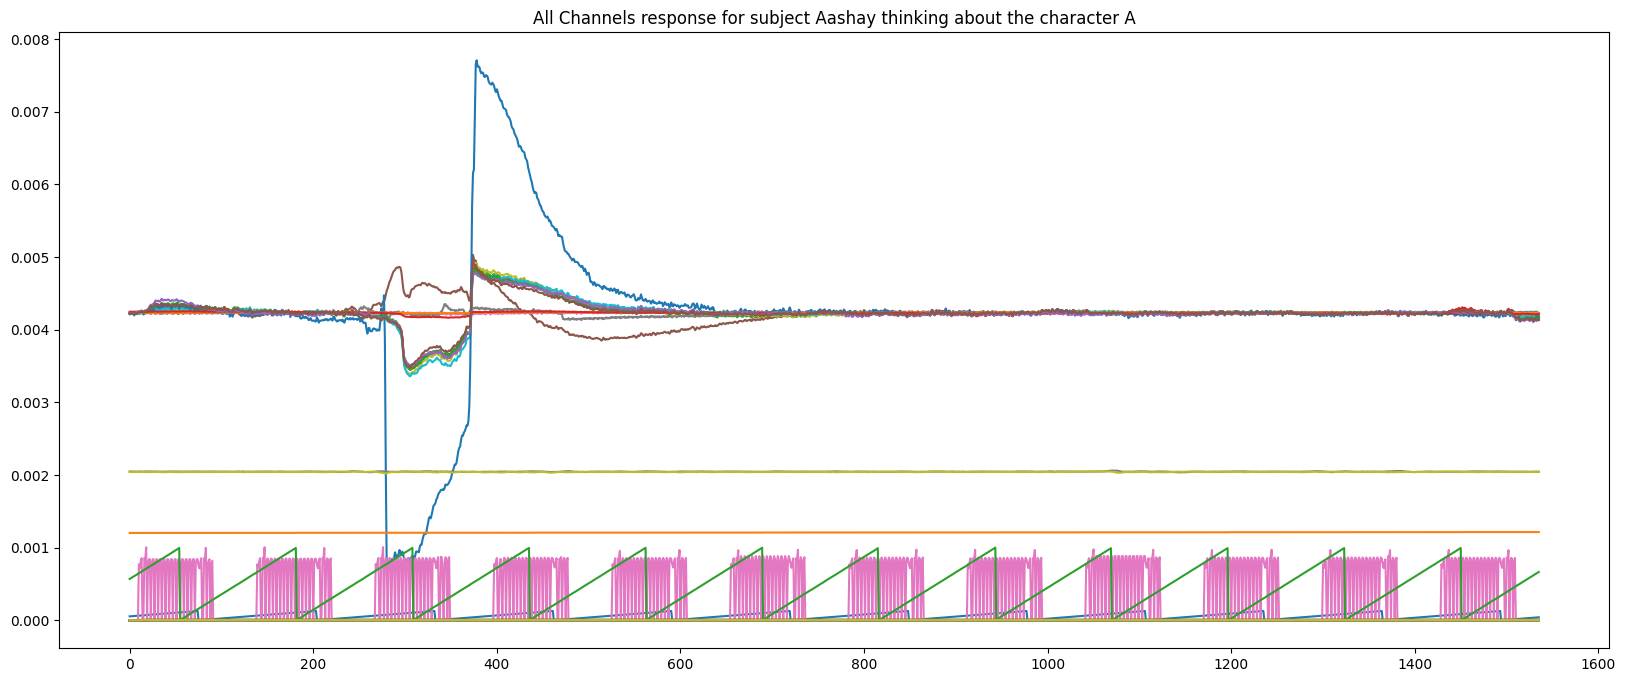

In [8]:
def plot_channels(df, column):
    plt.rcParams["figure.figsize"] = (20,8)
    plt.plot(df[column], label = str(column))
    plt.title(f'All Channels response for subject Aashay thinking about the character A')

for c in channels:
    plot_channels(df = df_data, column=c)

In [9]:
mne.set_log_level('WARNING')

In [10]:
folder = 'Char/'

In [11]:
X = np.zeros((230,14,1280))
Y = np.zeros((230,))
ctr = 0
for file in os.listdir(folder):
    data = mne.io.read_raw_edf(os.path.join(folder,file))
    raw_data = data[2:16][0]*1000
    raw_data = raw_data[:,0:1280]
    a = raw_data.shape
    
    _,cls = file.split('_')
    if cls[0]=='A':
        Y[ctr] = 0
    elif cls[0]=='C':
        Y[ctr] = 1 
    elif cls[0]=='F':
        Y[ctr] = 2
    elif cls[0]=='H':
        Y[ctr] = 3
    elif cls[0]=='J':
        Y[ctr] = 4
    elif cls[0]=='M':
        Y[ctr] = 5
    elif cls[0]=='P':
        Y[ctr] = 6
    elif cls[0]=='S':
        Y[ctr] = 7
    elif cls[0]=='T':
        Y[ctr] = 8
    elif cls[0]=='Y':
        Y[ctr] = 9
    X[ctr,:,:] = raw_data
    ctr += 1


In [12]:
print(X.shape)
print(Y.shape)

(230, 14, 1280)
(230,)
